In [173]:
import xarray as xr
import matplotlib.pyplot as plt
from stompy import utils
from matplotlib import cm
import numpy as np
import six
import os
import pandas as pd
from stompy.grid import unstructured_grid
from stompy.model.fish_ptm import ptm_tools
%matplotlib notebook

In [174]:
six.moves.reload_module(unstructured_grid)

<module 'stompy.grid.unstructured_grid' from '/home/rusty/src/stompy/stompy/grid/unstructured_grid.py'>

In [175]:
try:
    ptm_hyd.close()
except NameError:
    pass
ptm_hyd=xr.open_dataset('/opt2/sfb_ocean/suntans/runs/merged_021_20170610/ptm_average.nc_0000.nc')

In [176]:
try:
    sun_hyd.close()
except NameError:
    pass

sun_hyd=xr.open_dataset('/opt2/sfb_ocean/suntans/runs/merged_021_20170610/average.nc_0000.nc')

sun_hyd=sun_hyd.rename_vars(dict(Nk='Nkc'))

In [177]:
g=unstructured_grid.UnstructuredGrid.from_ugrid(ptm_hyd)

In [178]:
ptm_run_dir='/opt2/sfb_ocean/ptm/all_source_021d/chunk00/test00'

#pbA=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'Alameda_Creek_up50000_rel20170730_bin.out'))
pbA=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'Alameda_Creek_surf_bin.out'))
#pbB=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'Alameda_Creek_up5000_rel20170730_bin.out'))
#pbC=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'Alameda_Creek_up500_rel20170730_bin.out'))
#pbD=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'Alameda_Creek_none_rel20170730_bin.out'))


In [179]:
# psA=ptm_tools.PtmState(os.path.join(ptm_run_dir,'Alameda_Creek_up50000_rel20170730_state.out'))
psA=ptm_tools.PtmState(os.path.join(ptm_run_dir,'Alameda_Creek_surf_state.out'))

In [180]:
psA.read_timestep(10)

(datetime.datetime(2017, 6, 11, 0, 30),
 array([( 1, [ 5.76381825e+05,  4.15771477e+06, -3.84925032e+00], 1, [-7.5244218e-02,  8.6004883e-02, -8.4896259e-05], 1.5286155, -3.96702  , 5.4956355),
        ( 2, [ 5.76383752e+05,  4.15771165e+06, -3.84917210e+00], 1, [-7.5323783e-02,  8.5910134e-02, -8.4329826e-05], 1.5286155, -3.96702  , 5.4956355),
        ( 3, [ 5.76385708e+05,  4.15770854e+06, -3.84908468e+00], 1, [-7.5401254e-02,  8.5817881e-02, -8.3766361e-05], 1.5286155, -3.96702  , 5.4956355),
        ( 4, [ 5.76387693e+05,  4.15770546e+06, -3.84898798e+00], 1, [-7.5476676e-02,  8.5728072e-02, -8.3205872e-05], 1.5286155, -3.96702  , 5.4956355),
        ( 5, [ 5.76389772e+05,  4.15770251e+06, -3.84922660e+00], 1, [-8.0798551e-02,  6.9485776e-02, -8.4307045e-05], 1.5291281, -3.9665074, 5.4956355),
        ( 6, [ 5.76391985e+05,  4.15769981e+06, -3.84934254e+00], 1, [-8.0752485e-02,  6.8631560e-02, -8.4264131e-05], 1.5291281, -3.9665074, 5.4956355),
        ( 7, [ 5.76394219e+05,  4.15

In [181]:
nt=200
npart=1
pbs=[pbA] # ,pbB,pbC,pbD]
posns=np.zeros((nt,len(pbs),npart,3),np.float64)
times=np.zeros(nt,'M8[us]')
steps=range(nt)

for pbi,pb in enumerate(pbs):
    for ti,ts in enumerate(steps):
        d,parts=pb.read_timestep(ts)
        posns[ti,pbi,:,:]=parts['x'][:npart,:]        
        times[ti]=utils.to_dt64(d)
theta=115.*np.pi/180.
vec_long=np.r_[ np.cos(theta), np.sin(theta), 0]

<IPython.core.display.Javascript object>


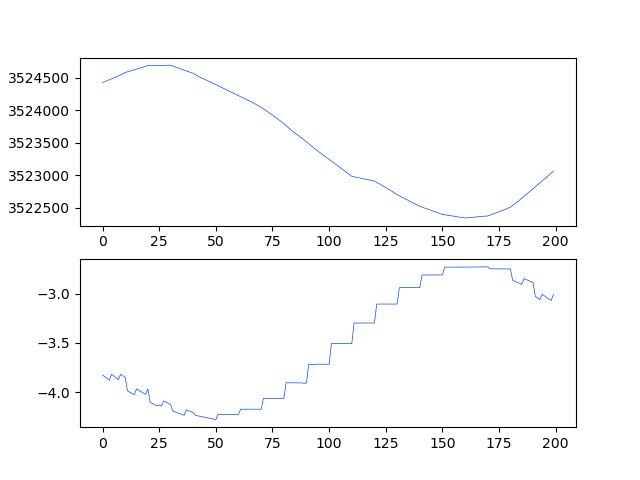

In [182]:
fig,(ax_long,ax_z)=plt.subplots(2,1)

colors=cm.jet(np.linspace(0.2,0.8,len(pbs)))

for pbi,col in zip(range(len(pbs)),colors):
    for p in range(npart):
        coord=posns[:,pbi,p,:].dot(vec_long)
        ax_long.plot(steps, coord, color=col,lw=0.5)
        ax_z.plot(steps,posns[:,pbi,p,2],color=col,lw=0.5)
        

In [183]:
part_i=0
xyz=posns[:,0,part_i,:]

part_df=pd.DataFrame(dict(time=times,x=xyz[:,0],y=xyz[:,1],z=xyz[:,2]))

In [184]:
# What *should* the particles horizontal velocity be?
#def part_hydro_vel(t,xyz):

part_df['cell']=[ g.select_cells_nearest( xyz[:2],inside='try')
                 for xyz in part_df.loc[:,['x','y','z']].values ]

In [185]:
# Add in state output

npart=1
pbs=[pbA] #,pbB,pbC,pbD]
posns=np.zeros((nt,len(pbs),npart,3),np.float64)
times=np.zeros(nt,'M8[us]')
steps=range(nt)


state_recs=[]
for ti,ts in enumerate(steps):
    d,states=psA.read_timestep(ts)
    state_recs.append(states[part_i].copy())

states=np.array(state_recs)
states.dtype

part_df['ptm_u']=states['u'][:,0]
part_df['ptm_v']=states['u'][:,1]
part_df['ptm_w']=states['u'][:,2]
part_df['ptm_depth']=states['water_depth']
part_df['ptm_eta']=states['water_level']
part_df['ptm_zbed']=-states['bed_elevation']

In [186]:
part_df.head()

,time,x,y,z,cell,ptm_u,ptm_v,ptm_w,ptm_depth,ptm_eta,ptm_zbed
0,2017-06-11 00:00:00,576500.500000,4.157599e+06,-3.826607,23225,0.000000,0.000000,0.000000,1.677417,-3.818219,-5.495636
1,2017-06-11 00:03:00,576490.036653,4.157610e+06,-3.842867,23225,-0.056734,0.061539,-0.000090,1.677417,-3.818219,-5.495636
2,2017-06-11 00:06:00,576478.950512,4.157621e+06,-3.860417,8499,-0.062656,0.061070,-0.000100,1.676858,-3.818777,-5.495636
3,2017-06-11 00:09:00,576467.764812,4.157632e+06,-3.879626,8499,-0.062370,0.061005,-0.000104,1.676858,-3.818777,-5.495636
4,2017-06-11 00:12:00,576456.659585,4.157643e+06,-3.818827,8499,-0.061911,0.060891,0.021608,1.676858,-3.818777,-5.495636


In [187]:
z_bed=-ptm_hyd.Mesh2_face_depth.values
part_df['z_bed']=z_bed[ part_df['cell'].values ]

In [188]:
# Eta - gets linearly interpolated.

hyd_times=ptm_hyd.Mesh2_data_time.values
# side='right' gives alpha in [0,1.)
# otherwise get alpha in (0,1]
hydro_step0=np.searchsorted(hyd_times,part_df['time'],side='left')-1
assert np.all(hydro_step0>=0)

part_df['alpha']=(part_df['time']-hyd_times[hydro_step0])/np.diff(hyd_times)[hydro_step0]

In [189]:
eta0=np.diag(ptm_hyd.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=hydro_step0,
                                                      nMesh2_face=part_df['cell']).values)
eta1=np.diag(ptm_hyd.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=hydro_step0+1,
                                                      nMesh2_face=part_df['cell']).values)

part_df['eta0']=eta0
part_df['eta1']=eta1
part_df['eta_i']=(1-part_df['alpha'])*eta0 + part_df['alpha']*eta1

In [190]:
# Particle velocity -- reflects preceding interval
dt=np.r_[1,np.diff(part_df['time'])/np.timedelta64(1,'s')]
dx=np.r_[0,np.diff(part_df['x'].values)]
dy=np.r_[0,np.diff(part_df['y'].values)]
part_df['u']=dx/dt
part_df['v']=dy/dt

In [191]:
np.all(sun_hyd.time.values[:-1]==ptm_hyd.Mesh2_data_time.values)

True

In [192]:
sun_hyd.z_w

<xarray.DataArray 'z_w' (Nkw: 61)>
array([0.000000e+00, 4.387286e-01, 9.322983e-01, 1.487564e+00, 2.112238e+00,
       2.814997e+00, 3.605600e+00, 4.495029e+00, 5.495636e+00, 6.621319e+00,
       7.887712e+00, 9.312405e+00, 1.091518e+01, 1.271831e+01, 1.474683e+01,
       1.702891e+01, 1.959625e+01, 2.248451e+01, 2.573380e+01, 2.938926e+01,
       3.350164e+01, 3.812808e+01, 4.333282e+01, 4.918815e+01, 5.577540e+01,
       6.318605e+01, 7.152303e+01, 8.090214e+01, 9.145364e+01, 1.033241e+02,
       1.166783e+02, 1.317018e+02, 1.486033e+02, 1.676174e+02, 1.890083e+02,
       2.130731e+02, 2.401460e+02, 2.706030e+02, 3.048671e+02, 3.434142e+02,
       3.867797e+02, 4.355659e+02, 4.904503e+02, 5.521953e+02, 6.216585e+02,
       6.998045e+02, 7.877188e+02, 8.866224e+02, 9.978889e+02, 1.123064e+03,
       1.263885e+03, 1.422310e+03, 1.600537e+03, 1.801043e+03, 2.026612e+03,
       2.280378e+03, 2.565863e+03, 2.887035e+03, 3.248353e+03, 3.654836e+03,
       4.112129e+03])
Coordinates:
    z_

In [193]:
ucs=[]
vcs=[]
sun_ks=[]
is_lump=[]

z_w=sun_hyd.z_w.values

dzmin_surface=0.25

# SUNTANS average output velocity:
for idx,row in part_df.iterrows():
    ti=hydro_step0[idx]+1
    eta=sun_hyd.eta.isel(time=ti,Nc=row['cell']).item()
    depth=sun_hyd.dv.isel(Nc=row['cell']).item()
    
    k,ktop,kbot=np.searchsorted( z_w,[-row['z'],-eta,depth] )
    if k==ktop and (eta+z_w[ktop]<dzmin_surface) and (ktop<kbot):
        k=ktop+1
        is_lump.append(1)
    else:
        is_lump.append(0)
    sun_ks.append(k)
    sun_uc=sun_hyd.uc.isel(time=ti,Nc=row['cell'],Nk=k).item()
    sun_vc=sun_hyd.vc.isel(time=ti,Nc=row['cell'],Nk=k).item()
    ucs.append(sun_uc)
    vcs.append(sun_vc)
    
part_df['sun_uc']=ucs
part_df['sun_vc']=vcs
part_df['sun_k']=sun_ks
part_df['is_lump']=is_lump

In [194]:
part_df

,time,x,y,z,cell,ptm_u,ptm_v,ptm_w,ptm_depth,ptm_eta,...,alpha,eta0,eta1,eta_i,u,v,sun_uc,sun_vc,sun_k,is_lump
0,2017-06-11 00:00:00,576500.500000,4.157599e+06,-3.826607,23225,0.000000,0.000000,0.000000,1.677417,-3.818219,...,1.0,-3.494574,-3.656120,-3.656120,0.000000,0.000000,-0.066158,0.060050,7,0
1,2017-06-11 00:03:00,576490.036653,4.157610e+06,-3.842867,23225,-0.056734,0.061539,-0.000090,1.677417,-3.818219,...,0.1,-3.656120,-3.818219,-3.672330,-0.058130,0.062067,-0.058526,0.048810,7,0
2,2017-06-11 00:06:00,576478.950512,4.157621e+06,-3.860417,8499,-0.062656,0.061070,-0.000100,1.676858,-3.818777,...,0.2,-3.656796,-3.818777,-3.689193,-0.061590,0.061711,-0.066192,0.049078,7,0
3,2017-06-11 00:09:00,576467.764812,4.157632e+06,-3.879626,8499,-0.062370,0.061005,-0.000104,1.676858,-3.818777,...,0.3,-3.656796,-3.818777,-3.705391,-0.062143,0.060950,-0.066192,0.049078,7,0
4,2017-06-11 00:12:00,576456.659585,4.157643e+06,-3.818827,8499,-0.061911,0.060891,0.021608,1.676858,-3.818777,...,0.4,-3.656796,-3.818777,-3.721589,-0.061696,0.060833,-0.066192,0.049078,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2017-06-11 09:45:00,577398.619363,4.156377e+06,-3.020987,10476,-0.071190,0.149767,-0.000083,2.490281,-3.005355,...,0.5,-2.847707,-3.005355,-2.926531,-0.074668,0.145496,-0.066752,0.126261,6,0
196,2017-06-11 09:48:00,577384.791633,4.156405e+06,-3.036639,10475,-0.081687,0.152559,-0.000094,2.490060,-3.005575,...,0.6,-2.847918,-3.005575,-2.942512,-0.076821,0.151808,-0.072701,0.127522,6,0
197,2017-06-11 09:51:00,577370.305970,4.156432e+06,-3.054456,10475,-0.081141,0.151484,-0.000096,2.490060,-3.005575,...,0.7,-2.847918,-3.005575,-2.958278,-0.080476,0.150177,-0.072701,0.127522,6,0
198,2017-06-11 09:54:00,577356.150924,4.156459e+06,-3.068402,10473,-0.088188,0.156583,-0.000108,2.489529,-3.006107,...,0.8,-2.848449,-3.006107,-2.974575,-0.078639,0.152917,-0.077016,0.129167,6,0


<IPython.core.display.Javascript object>


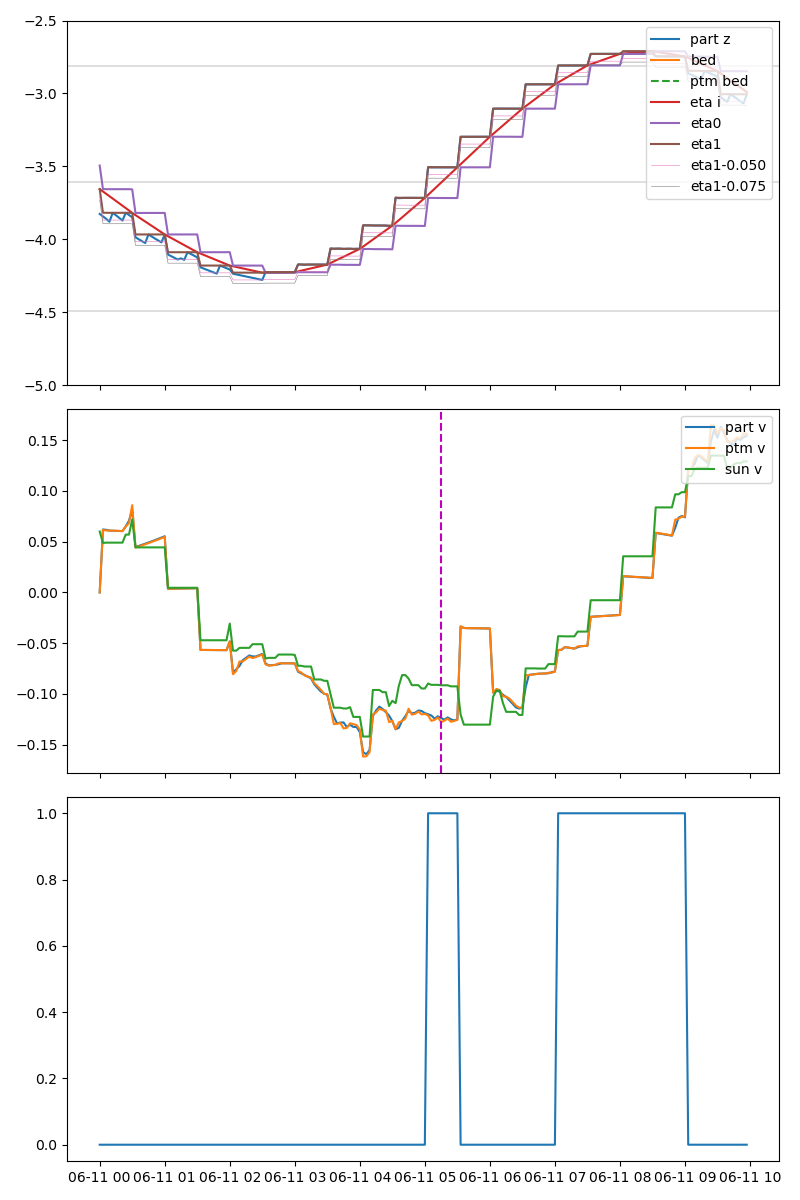

In [195]:
fig,(ax_z,ax_vel,ax_lump)=plt.subplots(3,1,sharex=True,figsize=(8,12))

ax_z.plot(part_df.time,part_df.z,label='part z')
ax_z.plot(part_df.time,part_df.z_bed,label='bed')
ax_z.plot(part_df.time,part_df.ptm_zbed,ls='--',label='ptm bed')
ax_z.plot(part_df.time,part_df.eta_i,label='eta i')
ax_z.plot(part_df.time,part_df.eta0,label='eta0')
ax_z.plot(part_df.time,part_df.eta1,label='eta1')

for z in sun_hyd.z_w.values[1:-1]:
    ax_z.axhline(-z,color='0.4',lw=0.3,zorder=-2,label='__nolabel__')

ax_z.plot(part_df.time,part_df.eta1-0.050,lw=0.4,label='eta1-0.050')
ax_z.plot(part_df.time,part_df.eta1-0.075,lw=0.4,label='eta1-0.075')

ax_z.legend(loc='upper right')
ax_z.axis(ymax=-2.5,ymin=-5)

#ax_vel.plot(part_df.time,part_df.u,label='part u')
ax_vel.plot(part_df.time,part_df.v,label='part v')
#ax_vel.plot(part_df.time,part_df.ptm_u,label='ptm u')
ax_vel.plot(part_df.time,part_df.ptm_v,label='ptm v')
#ax_vel.plot(part_df.time,part_df.sun_uc,label='sun u')
ax_vel.plot(part_df.time,part_df.sun_vc,label='sun v')

ax_vel.legend(loc='upper right')

ti_stall=105
ax_vel.axvline(part_df.time.values[ti_stall],color='m',ls='--')
ax_lump.plot(part_df.time,part_df.is_lump,label='surface lumped')
fig.tight_layout()

<IPython.core.display.Javascript object>


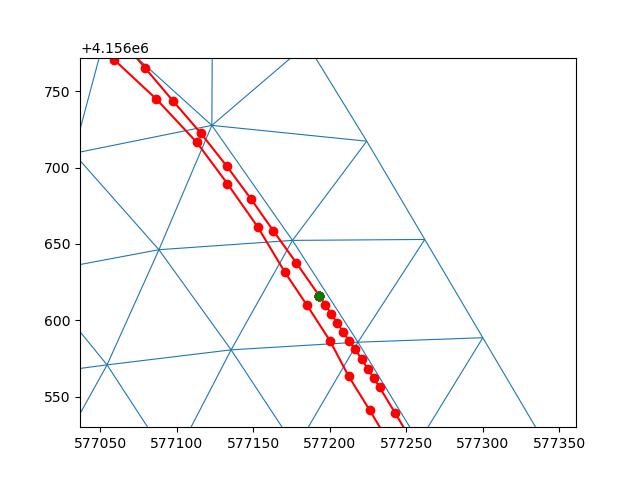

(577131.4354797219, 577266.2672849834, 4156530.1629177057, 4156771.9302926576)

In [89]:
fig,ax=plt.subplots()
g.plot_edges()
plt.plot( part_df['x'],part_df['y'],'r-o')
plt.plot( [part_df['x'].values[ti_stall]],[part_df['y'].values[ti_stall]],'go')
ax.set_adjustable('datalim')
ax.axis((577131.4354797219, 577266.2672849834, 4156530.1629177057, 4156771.9302926576))

In [128]:
xy=part_df.iloc[ti_stall,:][ ['x','y']].values
c=g.select_cells_nearest(xy,inside=True)
print("cell is ",c)
t=part_df.time.values[ti_stall]
print("time ",t)

hyd_ti=np.searchsorted( ptm_hyd.Mesh2_data_time.values, t)
print(f"ptm_hyd time[{hyd_ti-1}]={ptm_hyd.Mesh2_data_time.values[hyd_ti-1]}")
print(f"ptm_hyd time[{hyd_ti}]={ptm_hyd.Mesh2_data_time.values[hyd_ti]}")

part_z=part_df['z'].values[ti_stall]
print("Particle z:",part_z)
eta1=ptm_hyd.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=hyd_ti).values
print(f"ptm eta1={eta1[c]}")
print("  => %.7f below surface"%(eta1[c]- part_z))

z_w=ptm_hyd.Mesh2_layer_3d.values
k=np.searchsorted(-z_w,part_z)
print(f"z_w[k={k}]={-z_w[k]}")
print(f"z_w[k={k-1}]={-z_w[k-1]}")
part_k=k+1

print(f"particle k [1-based] = {part_k}")

kti=ptm_hyd.Mesh2_face_top_layer.isel(nMesh2_data_time=hyd_ti).values
print(f"cell top from ptm_hyd={kti[c]} [1-based]")

kti_calc=np.searchsorted(-z_w[:-1],eta1[c])+1
print(f"cell top from eta={kti_calc} [1-based]")

print("Last 10 z_w of %d: %s"%(len(z_w),z_w[-10:]))

U_F=ptm_hyd.h_flow_avg.isel(nMesh2_data_time=hyd_ti).values
ktj=ptm_hyd.Mesh2_edge_top_layer.isel(nMesh2_data_time=hyd_ti).values

for j in ptm_hyd.Mesh2_face_edges.values[c,:]:
    if j<0: break
    print(f"Adjacent edge: j={j} Q[k1={kti[c]}]={U_F[j,kti[c]-1]:.4f}  k1={kti[c]-1}: {U_F[j,kti[c]-2]:.4f}")
    print(f"  ktj1={ktj[j]}")
    
# is etop not calculated correctly here?


cell is  10570
time  2017-06-11T05:15:00.000000000
ptm_hyd time[58]=2017-06-11T05:00:00.000000000
ptm_hyd time[59]=2017-06-11T05:30:00.000000000
Particle z: -3.5060135639190673
ptm eta1=-3.505963560673913
  => 0.0000500 below surface
z_w[k=54]=-2.8149967
z_w[k=53]=-3.6055999
particle k [1-based] = 55
cell top from ptm_hyd=55 [1-based]
cell top from eta=55 [1-based]
Last 10 z_w of 60: [6.6213185 5.4956355 4.4950285 3.6055999 2.8149967 2.1122383 1.4875642
 0.9322983 0.4387286 0.       ]
Adjacent edge: j=70281 Q[k1=55]=-0.0000  k1=54: -0.0338
  ktj1=54
Adjacent edge: j=70439 Q[k1=55]=-0.0000  k1=54: 11.1815
  ktj1=54
Adjacent edge: j=70440 Q[k1=55]=-0.0000  k1=54: -9.8772
  ktj1=54


In [114]:
ptm_hyd.Mesh2_face_top_layer.isel(nMesh2_data_time=slice(hyd_ti-10,hyd_ti+10),nMesh2_face=c).values

array([54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56,
       56, 55, 55], dtype=int32)

In [122]:
ptm_hyd.h_flow_avg

<xarray.DataArray 'h_flow_avg' (nMesh2_edge: 105877, nMesh2_layer_3d: 60, nMesh2_data_time: 504)>
[3201720480 values with dtype=float64]
Coordinates:
    Mesh2_edge_x  (nMesh2_edge) float64 ...
    Mesh2_edge_y  (nMesh2_edge) float64 ...
Dimensions without coordinates: nMesh2_edge, nMesh2_layer_3d, nMesh2_data_time
Attributes:
    long_name:    Horizontal volume flux averaged over integration interval
    units:        m3 s-1
    coordinates:  Mesh2_edge_x Mesh2_edge_y Mesh2_edge_z_3d

In [123]:
U_F.shape

(105877, 60)

In [88]:
plt.axis()

(577131.4354797219, 577266.2672849834, 4156530.1629177057, 4156771.9302926576)